# <span style="color:red">1. Importing The Libraries</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import time

In [2]:
data_path = '/home/nguyenngocduong/Documents/Python/tomatoes/tomato_clean'
train_data = data_path + '/train'
valid_data =  data_path + '/val'
print(len(os.listdir(train_data)))

10


In [3]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import time
import torchvision
from torchvision.transforms import ToTensor
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from pathlib import Path 

In [4]:
# Định nghĩa transform để resize ảnh và chuẩn hóa
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize ảnh về kích thước 256x256
    transforms.ToTensor(),          # Chuyển đổi ảnh sang tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization cho RGB
])
#train data
train_data = datasets.ImageFolder(root = train_data, transform = transform)

#validation data
val_data = datasets.ImageFolder(root = valid_data, transform = transform)

In [5]:
train_loader = DataLoader(
    train_data,
    batch_size = 32,
    shuffle=True    # Shuffle lại mỗi lần
)
valid_loader = DataLoader(
    val_data,
    batch_size = 32,
    shuffle = True
)
for image, label in train_loader:
    print(f'Kich thuoc anh: {image.shape} ung voi nhan: {label.shape}')
    break;

Kich thuoc anh: torch.Size([32, 3, 256, 256]) ung voi nhan: torch.Size([32])


In [6]:
# Kiểm tra một batch dữ liệu
print(f"Train data length: {len(train_data)}")
print(f"Validation data length: {len(val_data)}")

Train data length: 10000
Validation data length: 1000


# Visualize Data

In [9]:
class_names = train_data.classes
print(f'So loai benh tren cay ca chua: {len(class_names)}')

So loai benh tren cay ca chua: 10


In [10]:
path = '/home/nguyenngocduong/Documents/Python/tomatoes/tomato_clean/train'
#Bacterial_spot = path + '/Tomato___Bacterial_spot'
#Early_blight = path + '/Tomato___Early_blight'
#Late_blight = path + '/Tomato___Late_blight'
Yellow_leaf = path + '/Tomato___Tomato_Yellow_Leaf_Curl_Virus'
Benh = [Yellow_leaf]
image_files = []
for path in Benh:
    for f in os.listdir(path):
        file_path = os.path.join(path, f)
        if os.path.isfile(file_path):
            image_files.append(f)
print(len(image_files))

1000


In [11]:
image_files[0].split('.')[0]

'Tomato___Tomato_Yellow_Leaf_Curl_Virus_0314'

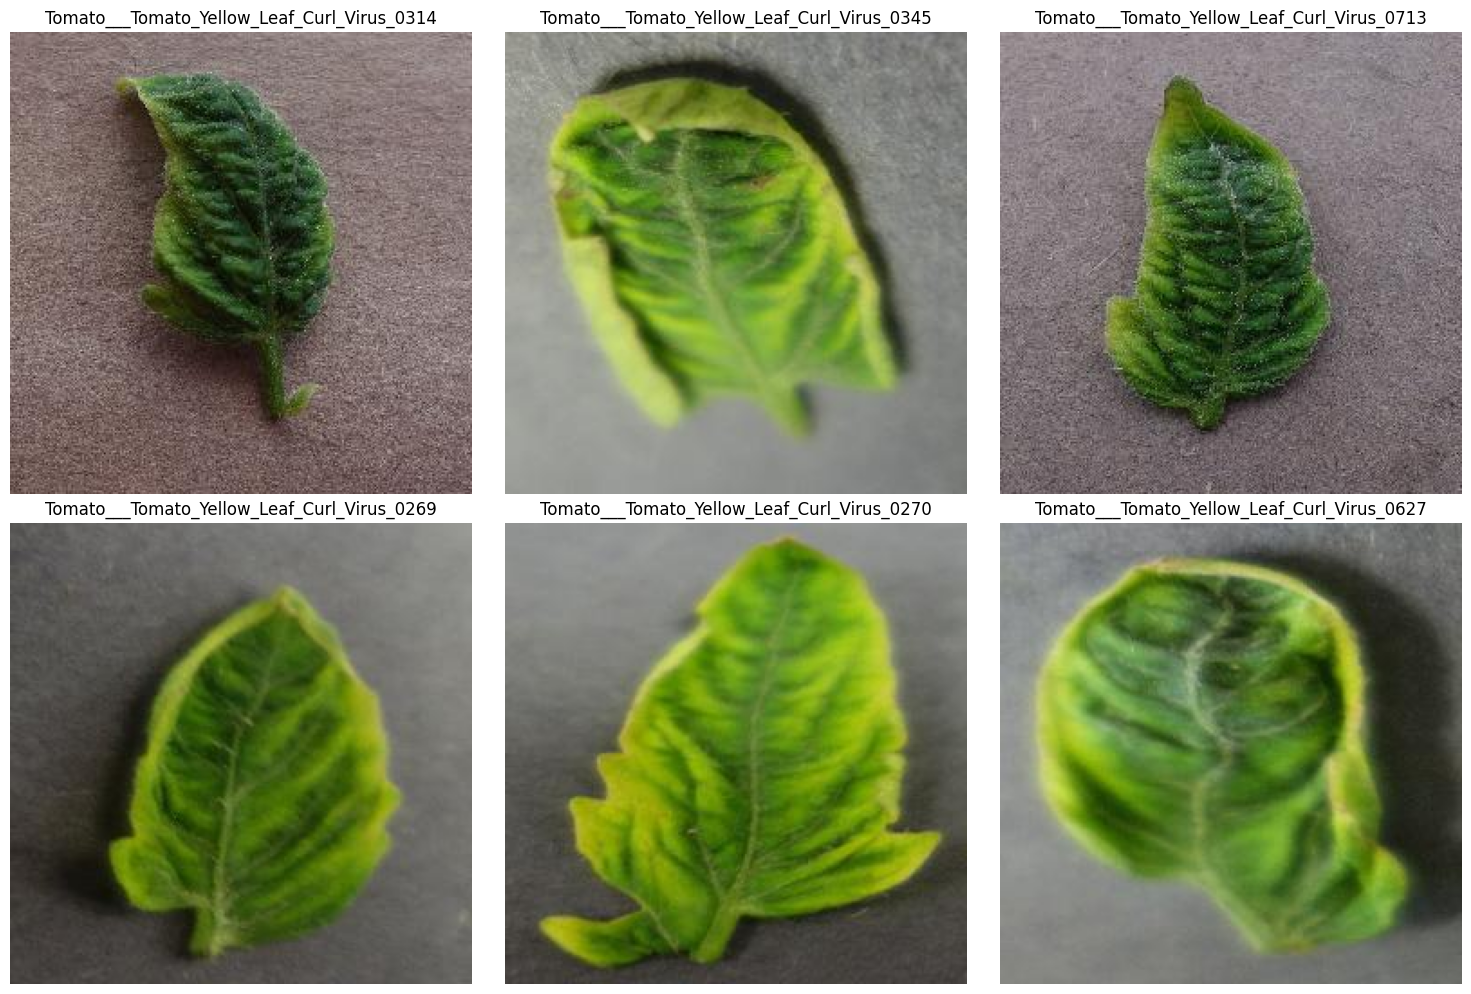

In [12]:
import matplotlib.image as mpimg 
# Path to the directory containing images
path = "/home/nguyenngocduong/Documents/Python/tomatoes/tomato_clean/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus"

# Get a list of all image file names in the directory
image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Display the first 6 images with their labels
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    # Get the image file name and its label
    image_file = image_files[i]
    label = image_file.split('.')[0]

    # Load and display the image
    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [13]:
def reshape_image_for_fuzzy(image_tensor):
    """
    Reshape anh 4D dang tensor (batch, channels, height, width) hoac anh 3D tensor (channels, height, width)
    bien doi thanh anh 2D array de clustering: (num_pixels, num_features).
    """
    if image_tensor.dim() == 4:
        # (batch, channels, height, width)
        b, c, h, w = image_tensor.shape
        return image_tensor.permute(0, 2, 3, 1).reshape(-1, c).cpu().numpy()
    elif image_tensor.dim() == 3:
        # (channels, height, width)
        c, h, w = image_tensor.shape
        return image_tensor.permute(1, 2, 0).reshape(-1, c).cpu().numpy()
    else:
        raise ValueError("Input tensor must be 3D or 4D")

In [14]:
train_data[0][0].shape  # Kich thuoc anh: (3, 256, 256)

torch.Size([3, 256, 256])

In [16]:
from skfuzzy.cluster import cmeans

def visualize_clustering(image_tensor,num_clusters):
    """
    Hiển thị ảnh gốc và ảnh sau khi phân cụm Fuzzy C-Means.
    """
    #num_clusters = 3  # So luong cluster
    # Chuyen doi anh sang dang 2D de su dung trong Fuzzy C-Means
    image_2d = reshape_image_for_fuzzy(image_tensor)
    cntr, u, u0, d, jm, p, fpc = cmeans(
        image_2d.T, num_clusters, 2, error=0.005,
        maxiter=1000, init=None, seed=42
    )
    #u la ma tran phan bo xs
    # cntr la trung tam cua cac cluster
    cluster_labels = np.argmax(u, axis=0)
    # Đưa về shape ảnh gốc (h, w)
    if image_tensor.dim() == 3:
        h, w = image_tensor.shape[1], image_tensor.shape[2]
    elif image_tensor.dim() == 4:
        h, w = image_tensor.shape[2], image_tensor.shape[3]
    else:
        raise ValueError("Input tensor must be 3D or 4D")
    clustered_img = cluster_labels.reshape(h, w)
    
    # Hiển thị ảnh gốc và ảnh phân cụm
    plt.figure(figsize=(10, 5))
    # Ảnh gốc (chuyển về [0,1] để hiển thị)
    img_np = image_tensor.clone().detach()
    if img_np.dim() == 3:
        img_np = img_np.permute(1, 2, 0).cpu().numpy()
    else:
        img_np = img_np[0].permute(1, 2, 0).cpu().numpy()
    # Đảo ngược normalization nếu cần
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = (img_np * std + mean)
    img_np = np.clip(img_np, 0, 1)
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Ảnh gốc")
    plt.axis('off')
    # Ảnh phân cụm
    plt.subplot(1, 2, 2)
    plt.imshow(clustered_img, cmap='viridis')
    plt.title(f"Ảnh sau phân cụm ({num_clusters} cụm)")
    plt.axis('off')

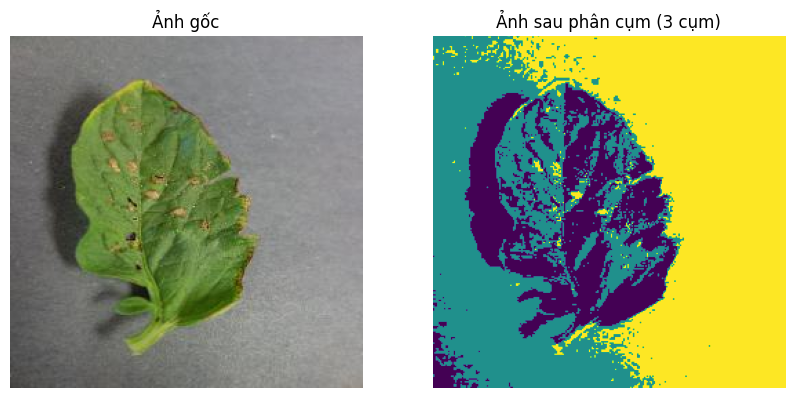

In [17]:
visualize_clustering(train_data[300][0], num_clusters = 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


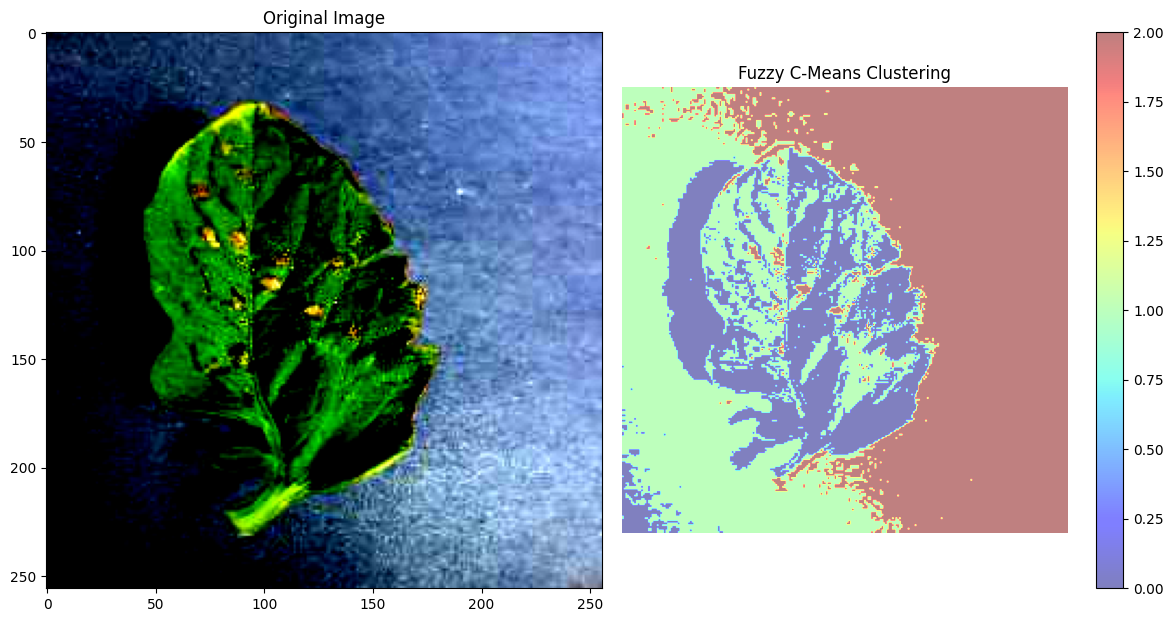

In [49]:
visualize_clustering(train_data[300][0], num_clusters = 3)

# Model MoE

In [18]:
# gan nhan
label = {
    'Tomato___Bacterial_spot': 'Bacterial',
    'Tomato___Early_blight': 'fungal',
    'Tomato___Late_blight': 'fungal',
    'Tomato___Leaf_Mold': 'fungal',
    'Tomato___Septoria_leaf_spot': 'fungal',
    'Tomato___Spider_mites Two-spotted_spider_mite': 'physiological',
    'Tomato___Target_Spot': 'fungal',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 'Bacterial',
    'Tomato___Tomato_mosaic_virus': 'Bacterial',
    'Tomato___healthy': 'physiological'
}

In [19]:
#Trích xuất đặc trưng từ phân cụm
cluster_unique, counts = np.unique(train_data[300][0].cpu().numpy(), return_counts=True)
print(f"Unique clusters: {cluster_unique}")
print(f"Counts of each cluster: {counts}")

Unique clusters: [-2.0836544  -1.9980307  -1.9481792  -1.9295317  -1.9124069  -1.8952821
 -1.8781574  -1.8610327  -1.843908   -1.8267832  -1.8096584  -1.8081232
 -1.8044444  -1.7925336  -1.7870152  -1.7754089  -1.7695861  -1.7582842
 -1.7521569  -1.7411594  -1.7380952  -1.7347276  -1.7240347  -1.7172985
 -1.7069099  -1.6998693  -1.6897851  -1.6855742  -1.68244    -1.6726604
 -1.6680672  -1.6650109  -1.6555357  -1.6505601  -1.6475817  -1.6384109
 -1.6330532  -1.6301525  -1.6212862  -1.6155462  -1.6127234  -1.6041614
 -1.5980392  -1.5952941  -1.5870366  -1.5805322  -1.5778649  -1.5699118
 -1.5630252  -1.5604358  -1.5527872  -1.5455182  -1.5430065  -1.5356624
 -1.5280112  -1.5255773  -1.5185376  -1.5105042  -1.5081482  -1.5014129
 -1.4929972  -1.490719   -1.4842881  -1.4754901  -1.4732897  -1.4671633
 -1.457983   -1.4558606  -1.4500387  -1.4404761  -1.4384314  -1.4329139
 -1.4229691  -1.4210021  -1.4157891  -1.405462   -1.403573   -1.3986644
 -1.3879551  -1.3861438  -1.3815396  -1.370448 

In [20]:
print(f"Total clusters: {cluster_unique.shape}")
print(f"Cluster labels: {cluster_unique}")

Total clusters: (558,)
Cluster labels: [-2.0836544  -1.9980307  -1.9481792  -1.9295317  -1.9124069  -1.8952821
 -1.8781574  -1.8610327  -1.843908   -1.8267832  -1.8096584  -1.8081232
 -1.8044444  -1.7925336  -1.7870152  -1.7754089  -1.7695861  -1.7582842
 -1.7521569  -1.7411594  -1.7380952  -1.7347276  -1.7240347  -1.7172985
 -1.7069099  -1.6998693  -1.6897851  -1.6855742  -1.68244    -1.6726604
 -1.6680672  -1.6650109  -1.6555357  -1.6505601  -1.6475817  -1.6384109
 -1.6330532  -1.6301525  -1.6212862  -1.6155462  -1.6127234  -1.6041614
 -1.5980392  -1.5952941  -1.5870366  -1.5805322  -1.5778649  -1.5699118
 -1.5630252  -1.5604358  -1.5527872  -1.5455182  -1.5430065  -1.5356624
 -1.5280112  -1.5255773  -1.5185376  -1.5105042  -1.5081482  -1.5014129
 -1.4929972  -1.490719   -1.4842881  -1.4754901  -1.4732897  -1.4671633
 -1.457983   -1.4558606  -1.4500387  -1.4404761  -1.4384314  -1.4329139
 -1.4229691  -1.4210021  -1.4157891  -1.405462   -1.403573   -1.3986644
 -1.3879551  -1.3861438  

In [22]:
print(f"Cluster labels: {counts.shape}")

Cluster labels: (558,)


In [23]:
from feature_extractor import *

threshold_1 = 0.5  # Ngưỡng mật độ đốm để phân loại bệnh nấm
threshold_2 = 0.3  # Ngưỡng biến dạng hình dạng lá để phân loại bệnh vi khuẩn/virus

def disease_router(image_tensor, num_clusters):
    # Phân tích đặc trưng chính bằng Fuzzy C-Means
    spot_density = analyze_spot_patterns(image_tensor, num_clusters)
    color_variance = analyze_color_distribution(image_tensor)
    shape_deformation = analyze_leaf_shape(image_tensor)
    if spot_density > threshold_1:
        return "fungal_expert"  # Expert 1
    elif shape_deformation > threshold_2:  
        return "bacterial_viral_expert"  # Expert 2  
    else:  
        return "physiological_expert"  # Expert 3


## Các mô hình ML cụ thể cho từng expert

In [34]:
from sklearn.metrics import accuracy_score, f1_score
from eval_res import *
from efficientnet_pytorch import EfficientNet
# Expert 1: Fungal Disease Specialist: model ResNet50/EfficientNet + CNN chuyên biệt
class FungalDiseaseExpert(nn.Module):
    def __init__(self):
        super().__init__()
        # Backbone: EfficientNet-B3 (tối ưu cho texture analysis)  
        self.backbone = EfficientNet.from_pretrained('efficientnet-b3')  

        # Specialized layers cho spot detection  
        self.spot_detector = nn.Sequential(  
            nn.Conv2d(1536, 512, 3, padding=1),  
            nn.BatchNorm2d(512),  
            nn.ReLU(),  
            nn.Conv2d(512, 256, 3, padding=1),  
            nn.AdaptiveAvgPool2d(1)  
        )  

        # Classifier cho 4 loại bệnh nấm + healthy  
        self.classifier = nn.Linear(256, 5)
    def forward(self,x):
        x = self.backbone.extract_features(x)  # Trích xuất đặc trưng từ EfficientNet
        x = self.spot_detector(x) # Trích xuất đặc trưng đốm
        x = x.view(x.size(0), -1) # chuyen thanh vector 
        x = self.classifier(x)
        return x

In [35]:
model = FungalDiseaseExpert()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /home/nguyenngocduong/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100.0%


Loaded pretrained weights for efficientnet-b3


FungalDiseaseExpert(
  (backbone): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStatic

In [ ]:
from preprocessing_fuzzy import *
from feature_extractor import *
from eval_res import *

num_clusters = 3
y_pred = []
y_true = []
expert_ids = []

for i in range(len(train_data)):
    image_tensor, label = train_data[i][0]
    # Phan cum
    img_2d = reshape_image_for_fuzzy(image_tensor)
    cntr, u, _, _, _, _, _ = cmeans(
        img_2d.T, num_clusters, 2, error=0.005,
        maxiter= 1000, init=None, seed= 42
    )
    cluster_labels = np.argmax(u, axis=0) 
    h, w = image_tensor.shape[1], image_tensor.shape[2]
    segmented_mask = cluster_labels.reshape(h, w)
    # phan tich dac trung
    #expert = disease_router(segmented_mask, num_clusters)
    # du doan 
        # Dự đoán với model (ví dụ với FungalDiseaseExpert)
    image_batch = image_tensor.unsqueeze(0)  # [1, 3, 256, 256]
    image_batch = image_batch.cuda() if next(model.parameters()).is_cuda else image_batch
    output = model(image_batch)
    pred = output.argmax(dim=1).item()
    y_true.append(label)
    y_pred.append(pred)

# Đánh giá kết quả
all_labels = list(range(5))  # Sửa lại theo số lớp thực tế
metrics = evaluate_moe(y_true, y_pred, y_pred, [], [], [], [], [], [], expert_ids, all_labels)
print(metrics)
